In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
os.chdir("drive/")
os.chdir('My Drive')
os.chdir('Experiment')
os.chdir('GNN')

In [3]:
OUTPUT_DIR = './gat-cora-outputs/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Nov 12 16:00:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!pip install igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.2 MB 38.0 MB/s 


In [6]:
!pip install cairocffi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 7.5 MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.4.0-py3-none-any.whl size=88776 sha256=6b69bc7126343a602a3ea4aeb76c6cfcdca6e5ea858cf89c6c45854150b20600
  Stored in directory: /root/.cache/pip/wheels/7a/2b/da/aec872f95d2c24105496ef149a9a576f52daf686f8f2127541
Successfully built cairocffi


In [7]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
from math import sqrt
import shutil
import string
import pickle
import random
import joblib
import itertools
import logging
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Visualization related imports
import matplotlib.pyplot as plt
import networkx as nx
import igraph as ig

# Main computation libraries
import scipy.sparse as sp

import enum

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
import torch.cuda.amp as amp

import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.12.1+cu113
env: TOKENIZERS_PARALLELISM=true


# Dataset

In [8]:
# Supported datasets - only Cora in this notebook
class DatasetType(enum.Enum):
    CORA = 0

    
# Networkx is not precisely made with drawing as its main feature but I experimented with it a bit
class GraphVisualizationTool(enum.Enum):
    NETWORKX = 0,
    IGRAPH = 1


# We'll be dumping and reading the data from this directory
CORA_PATH = os.path.join(os.getcwd(), 'cora')  # this is checked-in no need to make a directory


#
# Cora specific constants
#

# Thomas Kipf et al. first used this split in GCN paper and later Petar Veličković et al. in GAT paper
CORA_TRAIN_RANGE = [0, 140]  # we're using the first 140 nodes as the training nodes
CORA_VAL_RANGE = [140, 140+500]
CORA_TEST_RANGE = [1708, 1708+1000]
CORA_NUM_INPUT_FEATURES = 1433
CORA_NUM_CLASSES = 7

# Used whenever we need to visualzie points from different classes (t-SNE, CORA visualization)
cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

# Data Analysis

In [9]:
# First let's define these simple functions for loading/saving Pickle files - we need them for Cora

# All Cora data is stored as pickle
def pickle_read(path):
    with open(path, 'rb') as file:
        data = pickle.load(file)

    return data

def pickle_save(path, data):
    with open(path, 'wb') as file:
        pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
# We'll pass the training config dictionary a bit later
def load_graph_data(training_config, device):
    dataset_name = training_config['dataset_name'].lower()
    should_visualize = training_config['should_visualize']

    if dataset_name == DatasetType.CORA.name.lower():

        # shape = (N, FIN), where N is the number of nodes and FIN is the number of input features
        node_features_csr = pickle_read(os.path.join(CORA_PATH, 'node_features.csr'))
        # shape = (N, 1)
        node_labels_npy = pickle_read(os.path.join(CORA_PATH, 'node_labels.npy'))
        # shape = (N, number of neighboring nodes) <- this is a dictionary not a matrix!
        adjacency_list_dict = pickle_read(os.path.join(CORA_PATH, 'adjacency_list.dict'))

        # Normalize the features (helps with training)
        node_features_csr = normalize_features_sparse(node_features_csr)
        num_of_nodes = len(node_labels_npy)

        # shape = (2, E), where E is the number of edges, and 2 for source and target nodes. Basically edge index
        # contains tuples of the format S->T, e.g. 0->3 means that node with id 0 points to a node with id 3.
        topology = build_edge_index(adjacency_list_dict, num_of_nodes, add_self_edges=True)

        # Note: topology is just a fancy way of naming the graph structure data 
        # (aside from edge index it could be in the form of an adjacency matrix)

        if should_visualize:  # network analysis and graph drawing
            plot_in_out_degree_distributions(topology, num_of_nodes, dataset_name)  # we'll define these in a second
            visualize_graph(topology, node_labels_npy, dataset_name)

        # Convert to dense PyTorch tensors

        # Needs to be long int type because later functions like PyTorch's index_select expect it
        topology = torch.tensor(topology, dtype=torch.long, device=device)
        node_labels = torch.tensor(node_labels_npy, dtype=torch.long, device=device)  # Cross entropy expects a long int
        node_features = torch.tensor(node_features_csr.todense(), device=device)

        # Indices that help us extract nodes that belong to the train/val and test splits
        train_indices = torch.arange(CORA_TRAIN_RANGE[0], CORA_TRAIN_RANGE[1], dtype=torch.long, device=device)
        val_indices = torch.arange(CORA_VAL_RANGE[0], CORA_VAL_RANGE[1], dtype=torch.long, device=device)
        test_indices = torch.arange(CORA_TEST_RANGE[0], CORA_TEST_RANGE[1], dtype=torch.long, device=device)

        return node_features, node_labels, topology, train_indices, val_indices, test_indices
    else:
        raise Exception(f'{dataset_name} not yet supported.')


def normalize_features_sparse(node_features_sparse):
    assert sp.issparse(node_features_sparse), f'Expected a sparse matrix, got {node_features_sparse}.'

    # Instead of dividing (like in normalize_features_dense()) we do multiplication with inverse sum of features.
    # Modern hardware (GPUs, TPUs, ASICs) is optimized for fast matrix multiplications! ^^ (* >> /)
    # shape = (N, FIN) -> (N, 1), where N number of nodes and FIN number of input features
    node_features_sum = np.array(node_features_sparse.sum(-1))  # sum features for every node feature vector

    # Make an inverse (remember * by 1/x is better (faster) then / by x)
    # shape = (N, 1) -> (N)
    node_features_inv_sum = np.power(node_features_sum, -1).squeeze()

    # Again certain sums will be 0 so 1/0 will give us inf so we replace those by 1 which is a neutral element for mul
    node_features_inv_sum[np.isinf(node_features_inv_sum)] = 1.

    # Create a diagonal matrix whose values on the diagonal come from node_features_inv_sum
    diagonal_inv_features_sum_matrix = sp.diags(node_features_inv_sum)

    # We return the normalized features.
    return diagonal_inv_features_sum_matrix.dot(node_features_sparse)


def build_edge_index(adjacency_list_dict, num_of_nodes, add_self_edges=True):
    source_nodes_ids, target_nodes_ids = [], []
    seen_edges = set()

    for src_node, neighboring_nodes in adjacency_list_dict.items():
        for trg_node in neighboring_nodes:
            # if this edge hasn't been seen so far we add it to the edge index (coalescing - removing duplicates)
            if (src_node, trg_node) not in seen_edges:  # it'd be easy to explicitly remove self-edges (Cora has none..)
                source_nodes_ids.append(src_node)
                target_nodes_ids.append(trg_node)

                seen_edges.add((src_node, trg_node))

    if add_self_edges:
        source_nodes_ids.extend(np.arange(num_of_nodes))
        target_nodes_ids.extend(np.arange(num_of_nodes))

    # shape = (2, E), where E is the number of edges in the graph
    edge_index = np.row_stack((source_nodes_ids, target_nodes_ids))

    return edge_index

In [11]:
# Let's just define dummy visualization functions for now - just to stop Python interpreter from complaining!
# We'll define them in a moment, properly, I swear.

def plot_in_out_degree_distributions():
    pass

def visualize_graph():
    pass

config = {
    'dataset_name': DatasetType.CORA.name,
    'should_visualize': False
}

node_features, node_labels, edge_index, train_indices, val_indices, test_indices = load_graph_data(config, device)

print(node_features.shape, node_features.dtype)
print(node_labels.shape, node_labels.dtype)
print(edge_index.shape, edge_index.dtype)
print(train_indices.shape, train_indices.dtype)
print(val_indices.shape, val_indices.dtype)
print(test_indices.shape, test_indices.dtype)

torch.Size([2708, 1433]) torch.float32
torch.Size([2708]) torch.int64
torch.Size([2, 13264]) torch.int64
torch.Size([140]) torch.int64
torch.Size([500]) torch.int64
torch.Size([1000]) torch.int64


# Data Visualization

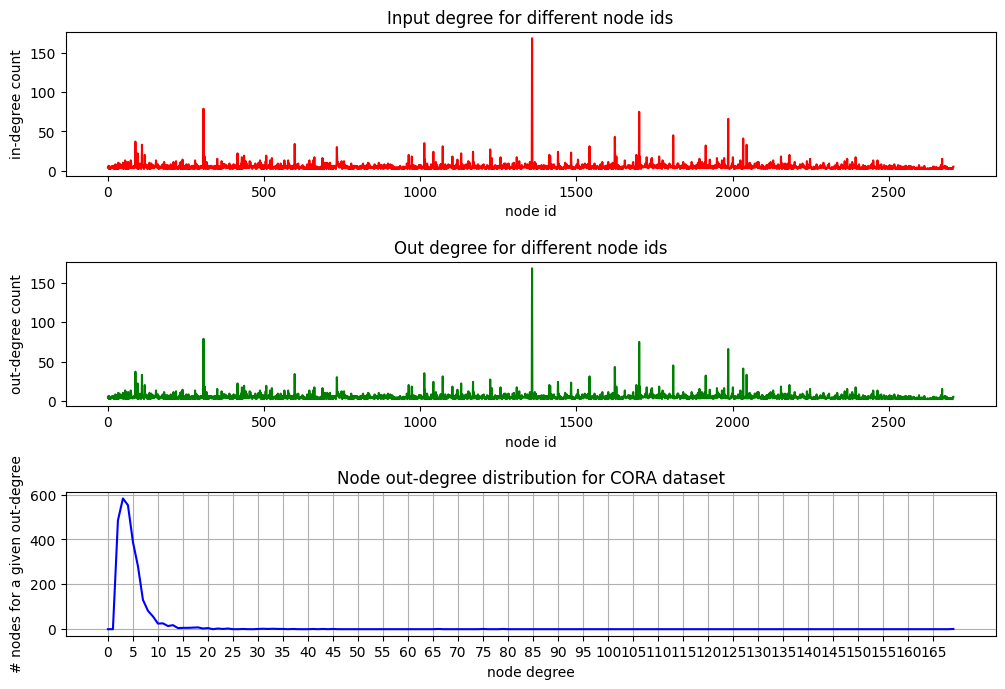

In [12]:
def plot_in_out_degree_distributions(edge_index, num_of_nodes, dataset_name):
    """
        Note: It would be easy to do various kinds of powerful network analysis using igraph/networkx, etc.
        I chose to explicitly calculate only the node degree statistics here, but you can go much further if needed and
        calculate the graph diameter, number of triangles and many other concepts from the network analysis field.

    """
    if isinstance(edge_index, torch.Tensor):
        edge_index = edge_index.cpu().numpy()
        
    assert isinstance(edge_index, np.ndarray), f'Expected NumPy array got {type(edge_index)}.'

    # Store each node's input and output degree (they're the same for undirected graphs such as Cora)
    in_degrees = np.zeros(num_of_nodes, dtype=np.int)
    out_degrees = np.zeros(num_of_nodes, dtype=np.int)

    # Edge index shape = (2, E), the first row contains the source nodes, the second one target/sink nodes
    # Note on terminology: source nodes point to target/sink nodes
    num_of_edges = edge_index.shape[1]
    for cnt in range(num_of_edges):
        source_node_id = edge_index[0, cnt]
        target_node_id = edge_index[1, cnt]

        out_degrees[source_node_id] += 1  # source node points towards some other node -> increment its out degree
        in_degrees[target_node_id] += 1  # similarly here

    hist = np.zeros(np.max(out_degrees) + 1)
    for out_degree in out_degrees:
        hist[out_degree] += 1

    fig = plt.figure(figsize=(12,8), dpi=100)  # otherwise plots are really small in Jupyter Notebook
    fig.subplots_adjust(hspace=0.6)

    plt.subplot(311)
    plt.plot(in_degrees, color='red')
    plt.xlabel('node id'); plt.ylabel('in-degree count'); plt.title('Input degree for different node ids')

    plt.subplot(312)
    plt.plot(out_degrees, color='green')
    plt.xlabel('node id'); plt.ylabel('out-degree count'); plt.title('Out degree for different node ids')

    plt.subplot(313)
    plt.plot(hist, color='blue')
    plt.xlabel('node degree')
    plt.ylabel('# nodes for a given out-degree') 
    plt.title(f'Node out-degree distribution for {dataset_name} dataset')
    plt.xticks(np.arange(0, len(hist), 5.0))

    plt.grid(True)
    plt.show()


num_of_nodes = len(node_labels)
plot_in_out_degree_distributions(edge_index, num_of_nodes, config['dataset_name'])

In [13]:
"""
Check out this blog for available graph visualization tools:
    https://towardsdatascience.com/large-graph-visualization-tools-and-approaches-2b8758a1cd59

Basically depending on how big your graph is there may be better drawing tools than igraph.

Note: I unfortunatelly had to flatten this function since igraph is having some problems with Jupyter Notebook,
we'll only call it here so it's fine!

"""

dataset_name = config['dataset_name']
visualization_tool=GraphVisualizationTool.IGRAPH

if isinstance(edge_index, torch.Tensor):
    edge_index_np = edge_index.cpu().numpy()

if isinstance(node_labels, torch.Tensor):
    node_labels_np = node_labels.cpu().numpy()

num_of_nodes = len(node_labels_np)
edge_index_tuples = list(zip(edge_index_np[0, :], edge_index_np[1, :]))  # igraph requires this format

# Construct the igraph graph
ig_graph = ig.Graph()
ig_graph.add_vertices(num_of_nodes)
ig_graph.add_edges(edge_index_tuples)

# Prepare the visualization settings dictionary
visual_style = {}

# Defines the size of the plot and margins
# go berserk here try (3000, 3000) it looks amazing in Jupyter!!! (you'll have to adjust the vertex_size though!)
visual_style["bbox"] = (700, 700)
visual_style["margin"] = 5

# I've chosen the edge thickness such that it's proportional to the number of shortest paths (geodesics)
# that go through a certain edge in our graph (edge_betweenness function, a simple ad hoc heuristic)

# line1: I use log otherwise some edges will be too thick and others not visible at all
# edge_betweeness returns < 1 for certain edges that's why I use clip as log would be negative for those edges
# line2: Normalize so that the thickest edge is 1 otherwise edges appear too thick on the chart
# line3: The idea here is to make the strongest edge stay stronger than others, 6 just worked, don't dwell on it

edge_weights_raw = np.clip(np.log(np.asarray(ig_graph.edge_betweenness())+1e-16), a_min=0, a_max=None)
edge_weights_raw_normalized = edge_weights_raw / np.max(edge_weights_raw)
edge_weights = [w**6 for w in edge_weights_raw_normalized]
visual_style["edge_width"] = edge_weights

# A simple heuristic for vertex size. Size ~ (degree / 4) (it gave nice results I tried log and sqrt as well)
visual_style["vertex_size"] = [deg / 4 for deg in ig_graph.degree()]

# This is the only part that's Cora specific as Cora has 7 labels
if dataset_name.lower() == DatasetType.CORA.name.lower():
    visual_style["vertex_color"] = [cora_label_to_color_map[label] for label in node_labels_np]
else:
    print('Feel free to add custom color scheme for your specific dataset. Using igraph default coloring.')

# Set the layout - the way the graph is presented on a 2D chart. Graph drawing is a subfield for itself!
# I used "Kamada Kawai" a force-directed method, this family of methods are based on physical system simulation.
# (layout_drl also gave nice results for Cora)
visual_style["layout"] = ig_graph.layout_kamada_kawai()

print('Plotting results ... (it may take couple of seconds).')
ig.plot(ig_graph, **visual_style)

Output hidden; open in https://colab.research.google.com to view.

# Model

In [14]:
class GATLayer(torch.nn.Module):
    # We'll use these constants in many functions so just extracting them here as member fields
    src_nodes_dim = 0  # position of source nodes in edge index
    trg_nodes_dim = 1  # position of target nodes in edge index

    # These may change in the inductive setting - leaving it like this for now (not future proof)
    nodes_dim = 0      # node dimension (axis is maybe a more familiar term nodes_dim is the position of "N" in tensor)
    head_dim = 1       # attention head dim

    def __init__(self, num_in_features, num_out_features, num_of_heads, concat=True, activation=nn.ELU(),
                 dropout_prob=0.6, add_skip_connection=True, bias=True, log_attention_weights=False):

        super().__init__()

        self.num_of_heads = num_of_heads
        self.num_out_features = num_out_features
        self.concat = concat  # whether we should concatenate or average the attention heads
        self.add_skip_connection = add_skip_connection

        #
        # Trainable weights: linear projection matrix (denoted as "W" in the paper), attention target/source
        # (denoted as "a" in the paper) and bias (not mentioned in the paper but present in the official GAT repo)
        #

        # You can treat this one matrix as num_of_heads independent W matrices
        self.linear_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)

        # After we concatenate target node (node i) and source node (node j) we apply the "additive" scoring function
        # which gives us un-normalized score "e". Here we split the "a" vector - but the semantics remain the same.
        # Basically instead of doing [x, y] (concatenation, x/y are node feature vectors) and dot product with "a"
        # we instead do a dot product between x and "a_left" and y and "a_right" and we sum them up
        self.scoring_fn_target = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))
        self.scoring_fn_source = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))

        # Bias is definitely not crucial to GAT - feel free to experiment (I pinged the main author, Petar, on this one)
        if bias and concat:
            self.bias = nn.Parameter(torch.Tensor(num_of_heads * num_out_features))
        elif bias and not concat:
            self.bias = nn.Parameter(torch.Tensor(num_out_features))
        else:
            self.register_parameter('bias', None)

        if add_skip_connection:
            self.skip_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)
        else:
            self.register_parameter('skip_proj', None)

        #
        # End of trainable weights
        #

        self.leakyReLU = nn.LeakyReLU(0.2)  # using 0.2 as in the paper, no need to expose every setting
        self.activation = activation
        # Probably not the nicest design but I use the same module in 3 locations, before/after features projection
        # and for attention coefficients. Functionality-wise it's the same as using independent modules.
        self.dropout = nn.Dropout(p=dropout_prob)

        self.log_attention_weights = log_attention_weights  # whether we should log the attention weights
        self.attention_weights = None  # for later visualization purposes, I cache the weights here

        self.init_params()
        
    def forward(self, data):
        #
        # Step 1: Linear Projection + regularization
        #

        in_nodes_features, edge_index = data  # unpack data
        num_of_nodes = in_nodes_features.shape[self.nodes_dim]
        assert edge_index.shape[0] == 2, f'Expected edge index with shape=(2,E) got {edge_index.shape}'

        # shape = (N, FIN) where N - number of nodes in the graph, FIN - number of input features per node
        # We apply the dropout to all of the input node features (as mentioned in the paper)
        # Note: for Cora features are already super sparse so it's questionable how much this actually helps
        in_nodes_features = self.dropout(in_nodes_features)

        # shape = (N, FIN) * (FIN, NH*FOUT) -> (N, NH, FOUT) where NH - number of heads, FOUT - num of output features
        # We project the input node features into NH independent output features (one for each attention head)
        nodes_features_proj = self.linear_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)

        nodes_features_proj = self.dropout(nodes_features_proj)  # in the official GAT imp they did dropout here as well

        #
        # Step 2: Edge attention calculation
        #

        # Apply the scoring function (* represents element-wise (a.k.a. Hadamard) product)
        # shape = (N, NH, FOUT) * (1, NH, FOUT) -> (N, NH, 1) -> (N, NH) because sum squeezes the last dimension
        # Optimization note: torch.sum() is as performant as .sum() in my experiments
        scores_source = (nodes_features_proj * self.scoring_fn_source).sum(dim=-1)
        scores_target = (nodes_features_proj * self.scoring_fn_target).sum(dim=-1)

        # We simply copy (lift) the scores for source/target nodes based on the edge index. Instead of preparing all
        # the possible combinations of scores we just prepare those that will actually be used and those are defined
        # by the edge index.
        # scores shape = (E, NH), nodes_features_proj_lifted shape = (E, NH, FOUT), E - number of edges in the graph
        scores_source_lifted, scores_target_lifted, nodes_features_proj_lifted = self.lift(scores_source, scores_target, nodes_features_proj, edge_index)
        scores_per_edge = self.leakyReLU(scores_source_lifted + scores_target_lifted)

        # shape = (E, NH, 1)
        attentions_per_edge = self.neighborhood_aware_softmax(scores_per_edge, edge_index[self.trg_nodes_dim], num_of_nodes)
        # Add stochasticity to neighborhood aggregation
        attentions_per_edge = self.dropout(attentions_per_edge)

        #
        # Step 3: Neighborhood aggregation
        #

        # Element-wise (aka Hadamard) product. Operator * does the same thing as torch.mul
        # shape = (E, NH, FOUT) * (E, NH, 1) -> (E, NH, FOUT), 1 gets broadcast into FOUT
        nodes_features_proj_lifted_weighted = nodes_features_proj_lifted * attentions_per_edge

        # This part sums up weighted and projected neighborhood feature vectors for every target node
        # shape = (N, NH, FOUT)
        out_nodes_features = self.aggregate_neighbors(nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes)

        #
        # Step 4: Residual/skip connections, concat and bias
        #

        out_nodes_features = self.skip_concat_bias(attentions_per_edge, in_nodes_features, out_nodes_features)
        return (out_nodes_features, edge_index)

    #
    # Helper functions (without comments there is very little code so don't be scared!)
    #

    def neighborhood_aware_softmax(self, scores_per_edge, trg_index, num_of_nodes):
        """
        As the fn name suggest it does softmax over the neighborhoods. Example: say we have 5 nodes in a graph.
        Two of them 1, 2 are connected to node 3. If we want to calculate the representation for node 3 we should take
        into account feature vectors of 1, 2 and 3 itself. Since we have scores for edges 1-3, 2-3 and 3-3
        in scores_per_edge variable, this function will calculate attention scores like this: 1-3/(1-3+2-3+3-3)
        (where 1-3 is overloaded notation it represents the edge 1-3 and its (exp) score) and similarly for 2-3 and 3-3
         i.e. for this neighborhood we don't care about other edge scores that include nodes 4 and 5.

        Note:
        Subtracting the max value from logits doesn't change the end result but it improves the numerical stability
        and it's a fairly common "trick" used in pretty much every deep learning framework.
        Check out this link for more details:

        https://stats.stackexchange.com/questions/338285/how-does-the-subtraction-of-the-logit-maximum-improve-learning

        """
        # Calculate the numerator. Make logits <= 0 so that e^logit <= 1 (this will improve the numerical stability)
        scores_per_edge = scores_per_edge - scores_per_edge.max()
        exp_scores_per_edge = scores_per_edge.exp()  # softmax

        # Calculate the denominator. shape = (E, NH)
        neigborhood_aware_denominator = self.sum_edge_scores_neighborhood_aware(exp_scores_per_edge, trg_index, num_of_nodes)

        # 1e-16 is theoretically not needed but is only there for numerical stability (avoid div by 0) - due to the
        # possibility of the computer rounding a very small number all the way to 0.
        attentions_per_edge = exp_scores_per_edge / (neigborhood_aware_denominator + 1e-16)

        # shape = (E, NH) -> (E, NH, 1) so that we can do element-wise multiplication with projected node features
        return attentions_per_edge.unsqueeze(-1)

    def sum_edge_scores_neighborhood_aware(self, exp_scores_per_edge, trg_index, num_of_nodes):
        # The shape must be the same as in exp_scores_per_edge (required by scatter_add_) i.e. from E -> (E, NH)
        trg_index_broadcasted = self.explicit_broadcast(trg_index, exp_scores_per_edge)

        # shape = (N, NH), where N is the number of nodes and NH the number of attention heads
        size = list(exp_scores_per_edge.shape)  # convert to list otherwise assignment is not possible
        size[self.nodes_dim] = num_of_nodes
        neighborhood_sums = torch.zeros(size, dtype=exp_scores_per_edge.dtype, device=exp_scores_per_edge.device)

        # position i will contain a sum of exp scores of all the nodes that point to the node i (as dictated by the
        # target index)
        neighborhood_sums.scatter_add_(self.nodes_dim, trg_index_broadcasted, exp_scores_per_edge)

        # Expand again so that we can use it as a softmax denominator. e.g. node i's sum will be copied to
        # all the locations where the source nodes pointed to i (as dictated by the target index)
        # shape = (N, NH) -> (E, NH)
        return neighborhood_sums.index_select(self.nodes_dim, trg_index)

    def aggregate_neighbors(self, nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes):
        size = list(nodes_features_proj_lifted_weighted.shape)  # convert to list otherwise assignment is not possible
        size[self.nodes_dim] = num_of_nodes  # shape = (N, NH, FOUT)
        out_nodes_features = torch.zeros(size, dtype=in_nodes_features.dtype, device=in_nodes_features.device)

        # shape = (E) -> (E, NH, FOUT)
        trg_index_broadcasted = self.explicit_broadcast(edge_index[self.trg_nodes_dim], nodes_features_proj_lifted_weighted)
        # aggregation step - we accumulate projected, weighted node features for all the attention heads
        # shape = (E, NH, FOUT) -> (N, NH, FOUT)
        out_nodes_features.scatter_add_(self.nodes_dim, trg_index_broadcasted, nodes_features_proj_lifted_weighted)

        return out_nodes_features

    def lift(self, scores_source, scores_target, nodes_features_matrix_proj, edge_index):
        """
        Lifts i.e. duplicates certain vectors depending on the edge index.
        One of the tensor dims goes from N -> E (that's where the "lift" comes from).

        """
        src_nodes_index = edge_index[self.src_nodes_dim]
        trg_nodes_index = edge_index[self.trg_nodes_dim]

        # Using index_select is faster than "normal" indexing (scores_source[src_nodes_index]) in PyTorch!
        scores_source = scores_source.index_select(self.nodes_dim, src_nodes_index)
        scores_target = scores_target.index_select(self.nodes_dim, trg_nodes_index)
        nodes_features_matrix_proj_lifted = nodes_features_matrix_proj.index_select(self.nodes_dim, src_nodes_index)

        return scores_source, scores_target, nodes_features_matrix_proj_lifted

    def explicit_broadcast(self, this, other):
        # Append singleton dimensions until this.dim() == other.dim()
        for _ in range(this.dim(), other.dim()):
            this = this.unsqueeze(-1)

        # Explicitly expand so that shapes are the same
        return this.expand_as(other)

    def init_params(self):
        """
        The reason we're using Glorot (aka Xavier uniform) initialization is because it's a default TF initialization:
            https://stackoverflow.com/questions/37350131/what-is-the-default-variable-initializer-in-tensorflow

        The original repo was developed in TensorFlow (TF) and they used the default initialization.
        Feel free to experiment - there may be better initializations depending on your problem.

        """
        nn.init.xavier_uniform_(self.linear_proj.weight)
        nn.init.xavier_uniform_(self.scoring_fn_target)
        nn.init.xavier_uniform_(self.scoring_fn_source)

        if self.bias is not None:
            torch.nn.init.zeros_(self.bias)

    def skip_concat_bias(self, attention_coefficients, in_nodes_features, out_nodes_features):
        if self.log_attention_weights:  # potentially log for later visualization in playground.py
            self.attention_weights = attention_coefficients

        if self.add_skip_connection:  # add skip or residual connection
            if out_nodes_features.shape[-1] == in_nodes_features.shape[-1]:  # if FIN == FOUT
                # unsqueeze does this: (N, FIN) -> (N, 1, FIN), out features are (N, NH, FOUT) so 1 gets broadcast to NH
                # thus we're basically copying input vectors NH times and adding to processed vectors
                out_nodes_features += in_nodes_features.unsqueeze(1)
            else:
                # FIN != FOUT so we need to project input feature vectors into dimension that can be added to output
                # feature vectors. skip_proj adds lots of additional capacity which may cause overfitting.
                out_nodes_features += self.skip_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)

        if self.concat:
            # shape = (N, NH, FOUT) -> (N, NH*FOUT)
            out_nodes_features = out_nodes_features.view(-1, self.num_of_heads * self.num_out_features)
        else:
            # shape = (N, NH, FOUT) -> (N, FOUT)
            out_nodes_features = out_nodes_features.mean(dim=self.head_dim)

        if self.bias is not None:
            out_nodes_features += self.bias

        return out_nodes_features if self.activation is None else self.activation(out_nodes_features)


class GAT(torch.nn.Module):
    """
    The most interesting and hardest implementation is implementation #3.
    Imp1 and imp2 differ in subtle details but are basically the same thing.

    So I'll focus on imp #3 in this notebook.

    """

    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, add_skip_connection=True, bias=True,
                 dropout=0.6, log_attention_weights=False):
        super().__init__()
        assert num_of_layers == len(num_heads_per_layer) == len(num_features_per_layer) - 1, f'Enter valid arch params.'

        num_heads_per_layer = [1] + num_heads_per_layer  # trick - so that I can nicely create GAT layers below

        gat_layers = []  # collect GAT layers
        for i in range(num_of_layers):
            layer = GATLayer(
                num_in_features=num_features_per_layer[i] * num_heads_per_layer[i],  # consequence of concatenation
                num_out_features=num_features_per_layer[i+1],
                num_of_heads=num_heads_per_layer[i+1],
                concat=True if i < num_of_layers - 1 else False,  # last GAT layer does mean avg, the others do concat
                activation=nn.ELU() if i < num_of_layers - 1 else None,  # last layer just outputs raw scores
                dropout_prob=dropout,
                add_skip_connection=add_skip_connection,
                bias=bias,
                log_attention_weights=log_attention_weights
            )
            gat_layers.append(layer)

        self.gat_net = nn.Sequential(
            *gat_layers,
        )


    def forward(self, data):
        return self.gat_net(data)

# Train

In [15]:
from torch.utils.tensorboard import SummaryWriter 

class LoopPhase(enum.Enum):
    TRAIN = 0,
    VAL = 1,
    TEST = 2

writer = SummaryWriter() 

BEST_VAL_ACC = 0
BEST_VAL_LOSS = 0
PATIENCE_CNT = 0
BINARIES_PATH = os.path.join(os.getcwd(), 'models', 'binaries')
CHECKPOINTS_PATH = os.path.join(os.getcwd(), 'models', 'checkpoints')

# Make sure these exist as the rest of the code assumes it
os.makedirs(BINARIES_PATH, exist_ok=True)
os.makedirs(CHECKPOINTS_PATH, exist_ok=True)

In [16]:
# import git
import re # regex

def get_training_state(training_config, model):
    training_state = {
        # "commit_hash": git.Repo(search_parent_directories=True).head.object.hexsha, # Training details
        "dataset_name": training_config['dataset_name'], 
        "num_of_epochs": training_config['num_of_epochs'], 
        "test_acc": training_config['test_acc'], # Model structure 
        "num_of_layers": training_config['num_of_layers'], 
        "num_heads_per_layer": training_config['num_heads_per_layer'], 
        "num_features_per_layer": training_config['num_features_per_layer'], 
        "add_skip_connection": training_config['add_skip_connection'], 
        "bias": training_config['bias'], 
        "dropout": training_config['dropout'], # Model state 
        "state_dict": model.state_dict()
    }
    return training_state


def print_model_metadata(training_state):
    header = f'\n{"*"*5} Model training metadata: {"*"*5}'
    print(header)
    
    for key, value in training_state.items():
        if key != 'state_dict':
            print(f'{key}: {value}')
            print(f'{"*" * len(header)}\n')


def get_available_binary_name():
    prefix = 'gat'

    def valid_binary_name(binary_name):
        pattern = re.compile(rf'{prefix}_[0-9]{{6}}\.pth')
        return re.fullmatch(pattern, binary_name) is not None

    valid_binary_names = list(filter(valid_binary_name, os.listdir(BINARIES_PATH)))
    
    if len(valid_binary_names) > 0:
        last_binary_name = sorted(valid_binary_names)[-1]
        new_suffix = int(last_binary_name.split('.')[0][-6:]) + 1 # increment by 1
        return f'{prefix}_{str(new_suffix).zfill(6)}.pth'
    return f'{prefix}_000000.pth'

In [17]:
import argparse


def get_training_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--num_of_epochs", type=int, help="number of training epochs", default=10000)
    parser.add_argument("--patience_period", type=int, help="number of epochs with no improvement on val before terminating", default=1000)
    parser.add_argument("--lr", type=float, help="model learning rate", default=5e-3)
    parser.add_argument("--weight_decay", type=float, help="L2 regularization on model weights", default=5e-4)
    parser.add_argument("--should_test", type=bool, help='should test the model on the test dataset?', default=True)
    parser.add_argument("--dataset_name", choices=[el.name for el in DatasetType], help='dataset to use for training', default=DatasetType.CORA.name)
    parser.add_argument("--should_visualize", type=bool, help='should visualize the dataset?', default=False)
    parser.add_argument("--enable_tensorboard", type=bool, help="enable tensorboard logging", default=False)
    parser.add_argument("--console_log_freq", type=int, help="log to output console (epoch) freq (None for no logging)", default=100)
    parser.add_argument("--checkpoint_freq", type=int, help="checkpoint model saving (epoch) freq (None for no logging)", default=1000)
    args = parser.parse_args("") # Model architecture related - this is the architecture as defined in the official paper (for Cora classification)
    
    gat_config = {
        "num_of_layers": 2, # GNNs, contrary to CNNs, are often shallow (it ultimately depends on the graph properties)
        "num_heads_per_layer": [8, 1], "num_features_per_layer": [CORA_NUM_INPUT_FEATURES, 8, CORA_NUM_CLASSES], 
        "add_skip_connection": False, # hurts perf on Cora
        "bias": True, # result is not so sensitive to bias
        "dropout": 0.6, # result is sensitive to dropout
    }
    
    training_config = dict()
    for arg in vars(args):
        training_config[arg] = getattr(args, arg) # Add additional config information 
    training_config.update(gat_config)
    return training_config

In [18]:
def get_main_loop(config, gat, cross_entropy_loss, optimizer, node_features, node_labels, edge_index, train_indices, val_indices, test_indices, patience_period, time_start):
    node_dim = 0 # this will likely change as soon as I add an inductive example (Cora is transductive)
    train_labels = node_labels.index_select(node_dim, train_indices)
    val_labels = node_labels.index_select(node_dim, val_indices)
    test_labels = node_labels.index_select(node_dim, test_indices)
    
    # node_features shape = (N, FIN), edge_index shape = (2, E)
    graph_data = (node_features, edge_index)
    
    def get_node_indices(phase):
        if phase == LoopPhase.TRAIN:
            return train_indices
        elif phase == LoopPhase.VAL:
            return val_indices
        else:
            return test_indices
        
    def get_node_labels(phase):
        if phase == LoopPhase.TRAIN:
            return train_labels
        elif phase == LoopPhase.VAL:
            return val_labels
        else:
            return test_labels

    def main_loop(phase, epoch=0):
        global BEST_VAL_ACC, BEST_VAL_LOSS, PATIENCE_CNT, writer # Certain modules behave differently depending on whether we're training the model or not. 
        
        if phase == LoopPhase.TRAIN:
            gat.train()
        else:
            gat.eval()
        
        node_indices = get_node_indices(phase)
        gt_node_labels = get_node_labels(phase) # gt stands for ground truth 
        
        # Do a forwards pass and extract only the relevant node scores (train/val or test ones) 
        # Note: [0] just extracts the node_features part of the data (index 1 contains the edge_index) 
        # shape = (N, C) where N is the number of nodes in the split (train/val/test) and C is the number of classes
        nodes_unnormalized_scores = gat(graph_data)[0].index_select(node_dim, node_indices) # Example: let's take an output for a single node on Cora - it's a vector of size 7 and it contains unnormalized 
        
        # scores like: V = [-1.393, 3.0765, -2.4445, 9.6219, 2.1658, -5.5243, -4.6247]
        # What PyTorch's cross entropy loss does is for every such vector it first applies a softmax, and so we'll
        # have the V transformed into: [1.6421e-05, 1.4338e-03, 5.7378e-06, 0.99797, 5.7673e-04, 2.6376e-07, 6.4848e-07]
        # secondly, whatever the correct class is (say it's 3), it will then take the element at position 3,
        # 0.99797 in this case, and the loss will be -log(0.99797). It does this for every node and applies a mean.
        # You can see that as the probability of the correct class for most nodes approaches 1 we get to 0 loss!
        loss = cross_entropy_loss(nodes_unnormalized_scores, gt_node_labels)
        if phase == LoopPhase.TRAIN:
            optimizer.zero_grad() # clean the trainable weights gradients in the computational graph (.grad fields)
            loss.backward() # compute the gradients for every trainable weight in the computational graph
            optimizer.step() # apply the gradients to weights
            
        # Finds the index of maximum (unnormalized) score for every node and that's the class prediction for that node.
        # Compare those to true (ground truth) labels and find the fraction of correct predictions -> accuracy metric.
        class_predictions = torch.argmax(nodes_unnormalized_scores, dim=-1)
        accuracy = torch.sum(torch.eq(class_predictions, gt_node_labels).long()).item() / len(gt_node_labels)
        
        # # Logging #
        if phase == LoopPhase.TRAIN:
            if config['enable_tensorboard']:
                writer.add_scalar('training_loss', loss.item(), epoch)
                writer.add_scalar('training_acc', accuracy, epoch)
        
            # Save model checkpoint
            if config['checkpoint_freq'] is not None and (epoch + 1) % config['checkpoint_freq'] == 0:
                ckpt_model_name = f"gat_ckpt_epoch_{epoch + 1}.pth"
                config['test_acc'] = -1
                torch.save(get_training_state(config, gat), os.path.join(CHECKPOINTS_PATH, ckpt_model_name))

        elif phase == LoopPhase.VAL:
            if config['enable_tensorboard']:
                writer.add_scalar('val_loss', loss.item(), epoch)
                writer.add_scalar('val_acc', accuracy, epoch)

            if config['console_log_freq'] is not None and epoch % config['console_log_freq'] == 0:
                print(f'GAT training: time elapsed={(time.time() - time_start):.2f} [s] | epoch={epoch + 1} | val acc={accuracy}')

            if accuracy > BEST_VAL_ACC or loss.item() < BEST_VAL_LOSS:
                BEST_VAL_ACC = max(accuracy, BEST_VAL_ACC)
                BEST_VAL_LOSS = min(loss.item(), BEST_VAL_LOSS)
                PATIENCE_CNT = 0 
            else:
                PATIENCE_CNT += 1
                
                if PATIENCE_CNT >= patience_period:
                    raise Exception('Stopping the training, the universe has no more patience for this training.')
        else:
            return accuracy # in the case of test phase we just report back the test accuracy
    
    return main_loop # return the decorated function

In [19]:
def train_gat(config):
    global BEST_VAL_ACC, BEST_VAL_LOSS
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Step 1: load the graph data
    node_features, node_labels, edge_index, train_indices, val_indices, test_indices = load_graph_data(config, device)
    
    # Step 2: prepare the model
    gat = GAT(
        num_of_layers=config['num_of_layers'], 
        num_heads_per_layer=config['num_heads_per_layer'], 
        num_features_per_layer=config['num_features_per_layer'], 
        add_skip_connection=config['add_skip_connection'], 
        bias=config['bias'], 
        dropout=config['dropout'], 
        log_attention_weights=False
    ).to(device)
    
    # Step 3: Prepare other training related utilities (loss & optimizer and decorator function)
    loss_fn = nn.CrossEntropyLoss(reduction='mean')
    optimizer = Adam(gat.parameters(), lr=config['lr'], weight_decay=config['weight_decay']) # THIS IS THE CORE OF THE TRAINING (we'll define it in a minute)
    
    # The decorator function makes things cleaner since there is a lot of redundancy between the train and val loops
    
    main_loop = get_main_loop(
        config, 
        gat, 
        loss_fn, 
        optimizer, 
        node_features, 
        node_labels, 
        edge_index, 
        train_indices, 
        val_indices, 
        test_indices, 
        config['patience_period'], 
        time.time()
    )
    
    BEST_VAL_ACC, BEST_VAL_LOSS, PATIENCE_CNT = [0, 0, 0] # reset vars used for early stopping
    
    # Step 4: Start the training procedure
    for epoch in range(config['num_of_epochs']): # Training loop 
        main_loop(phase=LoopPhase.TRAIN, epoch=epoch)
        # Validation loop 
        with torch.no_grad():
            try:
                main_loop(phase=LoopPhase.VAL, epoch=epoch)
            except Exception as e: # "patience has run out" exception :O 
                print(str(e)) 
                break # break out from the training loop
    

    if config['should_test']:
        test_acc = main_loop(phase=LoopPhase.TEST)
        config['test_acc'] = test_acc
        print(f'Test accuracy = {test_acc}')
    else:
        config['test_acc'] = -1
    
    # Save the latest GAT in the binaries directory
    torch.save(get_training_state(config, gat), os.path.join(BINARIES_PATH, get_available_binary_name()))



# Train the graph attention network (GAT)
train_gat(get_training_args())

GAT training: time elapsed=2.48 [s] | epoch=1 | val acc=0.184
GAT training: time elapsed=3.05 [s] | epoch=101 | val acc=0.782
GAT training: time elapsed=3.62 [s] | epoch=201 | val acc=0.786
GAT training: time elapsed=4.20 [s] | epoch=301 | val acc=0.796
GAT training: time elapsed=4.78 [s] | epoch=401 | val acc=0.788
GAT training: time elapsed=5.36 [s] | epoch=501 | val acc=0.806
GAT training: time elapsed=5.95 [s] | epoch=601 | val acc=0.816
GAT training: time elapsed=6.52 [s] | epoch=701 | val acc=0.796
GAT training: time elapsed=7.09 [s] | epoch=801 | val acc=0.804
GAT training: time elapsed=7.67 [s] | epoch=901 | val acc=0.802
GAT training: time elapsed=9.29 [s] | epoch=1001 | val acc=0.81
GAT training: time elapsed=9.87 [s] | epoch=1101 | val acc=0.808
GAT training: time elapsed=10.45 [s] | epoch=1201 | val acc=0.792
GAT training: time elapsed=11.03 [s] | epoch=1301 | val acc=0.804
Stopping the training, the universe has no more patience for this training.
Test accuracy = 0.813
